# 5 CV on Stemmed Words + Up-Sampling (Approach 3)

## 1) Import Packages

In [15]:
### BASIC PACKAGES
import pandas as pd
import numpy as np

### SKLEARN'S MACHINE LEARNING MODELS
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier

### METRICS CALCULATION
from sklearn import metrics

### SPACY'S STOP WORDS
from spacy.lang.en.stop_words import STOP_WORDS

### NLTK STEMMER
from nltk.stem.snowball import SnowballStemmer

### VISUALIZATION
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

In [16]:
new_stop_words = list(STOP_WORDS)
new_stop_words.append("buy")
print(sorted(new_stop_words))

['a', 'about', 'above', 'across', 'after', 'afterwards', 'again', 'against', 'all', 'almost', 'alone', 'along', 'already', 'also', 'although', 'always', 'am', 'among', 'amongst', 'amount', 'an', 'and', 'another', 'any', 'anyhow', 'anyone', 'anything', 'anyway', 'anywhere', 'are', 'around', 'as', 'at', 'back', 'be', 'became', 'because', 'become', 'becomes', 'becoming', 'been', 'before', 'beforehand', 'behind', 'being', 'below', 'beside', 'besides', 'between', 'beyond', 'both', 'bottom', 'but', 'buy', 'by', 'ca', 'call', 'can', 'cannot', 'could', 'did', 'do', 'does', 'doing', 'done', 'down', 'due', 'during', 'each', 'eight', 'either', 'eleven', 'else', 'elsewhere', 'empty', 'enough', 'even', 'ever', 'every', 'everyone', 'everything', 'everywhere', 'except', 'few', 'fifteen', 'fifty', 'first', 'five', 'for', 'former', 'formerly', 'forty', 'four', 'from', 'front', 'full', 'further', 'get', 'give', 'go', 'had', 'has', 'have', 'he', 'hence', 'her', 'here', 'hereafter', 'hereby', 'herein', 'h

## 2) ML with CV

In [17]:
# Pre-Processing:
# X = X or predictor variables, 1-D list or np.array
# y = y or target variables, 1-D list or np.array
# vect = CountVectorizer Text Preprocessor, needed for Text Analysis Machine Learning Model, CountVectorizer
# model = Machine Learning Model (E.g. Multinomial Naive Bayes, Linear SVC, LogisticRegression), sklearn ml model
# n_runs = Number of Runs to execute, int
# split_size = K fold Cross Validation, int
# print_itr = condition to print the iterations 

# Post-Processing:
# index = Index Labels of the data in the form of iter{iteration int}_cv_split{cv_split int}, list of int
# full_buy_words = list of lists of top 10 words in predicting label: "Buy", list of list of str
# full_sell_words = list of lists of top 10 words in predicting label: "Sell", list of list of str
# full_train_aucs = List of Areas Under Curve in predicting Training set data, list of float
# full_test_aucs = List of Areas Under Curve in predicting Testing set data, list of float
# full_train_accs = List of Accuracy Scores in predicting Training set data, list of float
# full_test_accs = List of Accuracy Scores in predicting Testing set data, list of float
# full_train_null_accs = List of Null Accuracy Scores in predicting Training set data, list of float
# full_test_null_accs = List of Null Accuracy Scores in predicting Testing set data, list of float
# full_test_conf_mats = Array of Confusion Matrix under the Test set, Numpy Array
# full_train_conf_mats = Array of Confusion Matrix under the Train set, Numpy Array

def ml_cv(X, y, vect, model, n_runs, split_size, print_itr):
    
    n_rows = len(y)

    ### RESULTS LISTS ###
    full_buy_words = []
    full_sell_words = []

    full_train_accs = []
    full_test_accs = []

    full_train_aucs = []
    full_test_aucs = []
    
    full_train_null_accs = []
    full_test_null_accs = []
    
    full_train_conf_mats = []
    full_test_conf_mats = []
    
    index = []
    
    classes = sorted(list(set(y)))
    all_pos_c0 = [a for a in range(len(y)) if y[a] == classes[0]]
    all_pos_c1 = [a for a in range(len(y)) if y[a] == classes[1]]
    
    n_c0 = len(all_pos_c0)
    n_c1 = len(all_pos_c1)
    
    cv_splits_c0 = [len(split_amts) for split_amts in np.array_split(list(range(n_c0)), split_size)]
    cv_splits_c1 = [len(split_amts) for split_amts in np.array_split(list(range(n_c1)), split_size)]
    
    for i in range(n_runs):
        if(print_itr):
            print("Run: {curr_run} out of {n_runs}".format(curr_run = i+1, n_runs = n_runs))
        
        all_pos = range(len(y))
        
        cv_set_pos_c0 = [a for a in range(len(y)) if y[a] == classes[0]]
        cv_set_pos_c1 = [a for a in range(len(y)) if y[a] == classes[1]]

        n_rows_c0 = len(all_pos_c0)
        n_rows_c1 = len(all_pos_c1)
        
        for cv in range(split_size):
            if(print_itr):
                print("Cross Validation: {curr_split} out of {split_size}".format(curr_split = cv + 1, split_size = split_size))
            
            if cv == split_size - 1:
                test_pos = cv_set_pos_c0 + cv_set_pos_c1
            else:
                test_pos_c0 = list(np.random.choice(cv_set_pos_c0, size = cv_splits_c0[cv], replace=False))
                test_pos_c1 = list(np.random.choice(cv_set_pos_c1, size = cv_splits_c1[cv], replace=False))
                test_pos = test_pos_c0 + test_pos_c1

            train_pos = list(set(all_pos) - set(test_pos))
            
            #print("train: ", train_pos, len(train_pos))
            #print("test: ", test_pos, len(test_pos))
            #print("Everything", list(set(train_pos + test_pos)), len(list(set(train_pos + test_pos))))
            
            X_train = [X[a] for a in train_pos]
            X_test = [X[a] for a in test_pos]
            y_train = [y[a] for a in train_pos]
            y_test = [y[a] for a in test_pos]

            cv_set_pos_c0 = list(set(cv_set_pos_c0) - set(test_pos_c0))
            cv_set_pos_c1 = list(set(cv_set_pos_c1) - set(test_pos_c1))

            #cv_vect2 = CountVectorizer(stop_words=STOP_WORDS)
            
            X_train_dtm = vect.fit_transform(X_train)
            X_test_dtm = vect.transform(X_test)

            #cv_lr2 = LogisticRegression()
            model.fit(X_train_dtm, y_train)
            
            # AREA UNDER CURVE SCORES
            if 'predict_proba' in dir(model):
                y_pred_test_prob = model.predict_proba(X_test_dtm)
                y_pred_train_prob = model.predict_proba(X_train_dtm)
                
                y_test_auc = metrics.roc_auc_score(y_score = [a[1] for a in y_pred_test_prob], y_true = y_test)
                y_train_auc = metrics.roc_auc_score(y_score = [a[1] for a in y_pred_train_prob], y_true = y_train)
            else:
                y_pred_test_prob = model.predict(X_test_dtm)
                y_pred_train_prob = model.predict(X_train_dtm)
                
                y_test_auc = metrics.roc_auc_score(y_score = y_pred_test_prob, y_true = y_test)
                y_train_auc = metrics.roc_auc_score(y_score = y_pred_train_prob, y_true = y_train)

            full_train_aucs.append(y_train_auc)
            full_test_aucs.append(y_test_auc)
            
            # PREDICTION ACCURACY SCORES
            y_pred_test_class = model.predict(X_test_dtm)
            y_pred_train_class = model.predict(X_train_dtm)
            
            train_acc_score = metrics.accuracy_score(y_pred=y_pred_train_class, y_true=y_train)
            test_acc_score = metrics.accuracy_score(y_pred=y_pred_test_class, y_true=y_test)
            
            full_train_accs.append(train_acc_score)
            full_test_accs.append(test_acc_score)
            
            # CONFUSION MATRIX
            full_train_conf_mats.append(metrics.confusion_matrix(y_true = y_train, y_pred = y_pred_train_class, labels = classes))
            full_test_conf_mats.append(metrics.confusion_matrix(y_true = y_test, y_pred = y_pred_test_class, labels = classes))
            
            # NULL ACCURACY SCORES
            train_classes = list(np.unique(y_train))
            test_classes = list(np.unique(y_test))
            
            train_most_occur_class = train_classes[1] if len([a for a in y_train if a == train_classes[1]])/len(y_train) >= 0.5 else train_classes[0]
            test_most_occur_class = test_classes[1] if len([a for a in y_test if a == test_classes[1]])/len(y_test) >= 0.5 else test_classes[0]
            
            train_null_acc = sum([1 for a in y_train if a == train_most_occur_class])/len(y_train)
            test_null_acc = sum([1 for a in y_test if a == test_most_occur_class])/len(y_test)
            
            full_train_null_accs.append(train_null_acc)
            full_test_null_accs.append(test_null_acc)
            
            # TOP 10 BUY AND SELL WORD PREDICTORS
            if 'coef_' in dir(model):
                df = pd.DataFrame({'coef': model.coef_[0], 'word': vect.get_feature_names()})
            elif 'feature_importances_' in dir(model):
                df = pd.DataFrame({'coef': model.feature_importances_, 'word': vect.get_feature_names()})
                
            buy_words_df = df.sort_values('coef', ascending=False)
            sell_words_df = df.sort_values('coef', ascending=True)
            buy_words = list(buy_words_df.word[:10])
            sell_words = list(sell_words_df.word[:10])

            full_buy_words.append(buy_words)
            full_sell_words.append(sell_words)
            
            # ITERATION AND SPLIT AS INDEXES
            curr_index = "iter{itr}_cv_split{cv_split}".format(itr = i + 1, cv_split = cv + 1)
            index.append(curr_index)
            
    return index, full_buy_words, full_sell_words, full_train_aucs, full_test_aucs, full_train_accs, full_test_accs, full_test_null_accs, full_train_null_accs, full_test_conf_mats, full_train_conf_mats


## 3) Stem All Tweets

In [18]:
### READ ALL TWEETS DATA
all_tweets = pd.read_csv('all_tweets_data.csv')

### STEM ALL TWEETS
stemmer = SnowballStemmer("english")
new_tweets_stem = []
for twt in all_tweets['new_tweets']:
    stem_words = [stemmer.stem(word) for word in twt.split(" ")]
    new_sentence = stem_words[0]
    for word in stem_words[1:]:
        new_sentence = new_sentence + " " + word
    new_tweets_stem.append(new_sentence)

### ADD NEWLY STEMMED TWEETS TO DF
all_tweets['new_tweets_stem'] = pd.Series(new_tweets_stem)
all_tweets

,X,Buy/Neutral/Sell,tweets,replies,retweets,favs,user,timeStamp,new_tweets,new_dts,assigned_member,coinMentioned,termsMentioned,new_tweets_stem
0,1,0,"<a href=""/hashtag/Substratum?src=hash"" data-qu...",88.0,376.0,807.0,officialmcafee,2018-02-02 13:19:00,alpha ii video w in this video you see just ho...,1.517549e+09,daryl,False,True,alpha ii video w in this video you see just ho...
1,2,0,"<a href=""https://t.co/WLJYQmRqOK"" rel=""nofollo...",156.0,72.0,215.0,officialmcafee,2018-02-02 10:37:00,price increase,1.517539e+09,daryl,False,True,price increas
2,3,0,Looking for a woman with ex SOF military exper...,416.0,206.0,1300.0,officialmcafee,2018-02-02 06:32:00,looking for a woman with ex sof military exper...,1.517524e+09,daryl,True,True,look for a woman with ex sof militari experi t...
3,5,1,"Coin Brothers - ""Buy the Fucking Dip""\n\n<a hr...",296.0,401.0,1300.0,officialmcafee,2018-02-02 04:19:00,coin brothers buy the fucking dip via,1.517516e+09,daryl,False,True,coin brother buy the fuck dip via
4,6,1,Lot's of people asking me over the past two da...,984.0,2100.0,6000.0,officialmcafee,2018-02-02 04:12:00,lot's of people asking me over the past two da...,1.517516e+09,daryl,True,True,lot of peopl ask me over the past two day whet...
5,8,0,Call for White papers: There are more than 50 ...,320.0,203.0,960.0,officialmcafee,2018-02-01 16:23:00,call for white papers there are more than new ...,1.517473e+09,daryl,False,True,call for white paper there are more than new i...
6,9,0,We are in a revolution against the waning powe...,1400.0,6400.0,15000.0,officialmcafee,2018-02-01 10:54:00,we are in a revolution against the waning powe...,1.517454e+09,daryl,True,True,we are in a revolut against the wane power of ...
7,11,0,Freelancers are 35% of the workforce. <a href=...,222.0,139.0,588.0,officialmcafee,2018-02-01 10:08:00,freelancers are of the workforce removes middl...,1.517451e+09,daryl,True,True,freelanc are of the workforc remov middlemen f...
8,14,0,"John McAfee Group Buy T-Shirt\n\n18,90 $ ! EU ...",57.0,45.0,169.0,officialmcafee,2018-01-30 13:04:00,john mcafee group buy tshirt eu amp usa free s...,1.517289e+09,daryl,True,True,john mcafe group buy tshirt eu amp usa free ship
9,16,1,"The <a href=""https://t.co/WLJYQmRqOK"" rel=""nof...",240.0,152.0,474.0,officialmcafee,2018-01-31 08:19:00,the ico is performing well the token price is ...,1.517358e+09,daryl,False,True,the ico is perform well the token price is go ...


## 4) Up-Sampling Tweets

For all the users, there is an imbalance in the tweet's signal types. Generally there are more "buy" signals as oppose to "sell" signals. Thus, we would want to upsample the "sell" signal which will help us perform 2 tasks. <br>

<ol>1. Balance the signal types of tweets for each user</ol>
<ol>2. Improve the learning ability of the models*</ol>

*It was observed that in approach 1 and 2, some models would plainly classify tweets to the most common class if not worst than the plain classifier. This would show that the learner has not effectively "learned" to classify tweets between both classes. This would explain why we received "information gain" <= 0. 

In [19]:
### Pre-Process
### X: Original Tweets as Series
### y: Original Target as Series

### Post-Process
### up_X: Up Sample Tweets as list
### up_y: Up Sample Targets as list

### Set the seed outside of this function so as not to always sample the way for each usage ###

def up_samp_data(X, y):
    class_val_counts = y.value_counts()
    classes = y.unique()
    
    if class_val_counts[classes[0]] < class_val_counts[classes[1]]:
        min_class, max_class = classes[0], classes[1]
    elif class_val_counts[classes[0]] > class_val_counts[classes[1]]:
        min_class, max_class = classes[1], classes[0]
    else:
        return list(X), list(y)
    
    up_X = list(X)
    up_y = list(y)
    
    min_class_pos_in_y = [pos for pos in range(len(up_y)) if up_y[pos] == min_class]
    
    up_samp_pos = np.random.randint(len(min_class_pos_in_y), size = class_val_counts[max_class] - class_val_counts[min_class])
    
    for pos in up_samp_pos:
        up_X.append(up_X[min_class_pos_in_y[pos]])
        up_y.append(up_y[min_class_pos_in_y[pos]])
        
    return up_X, up_y

In [31]:
### MAIN
all_users = all_tweets.user.unique()
print(all_users)
### Iterate for all user's tweets with the exception for user 1 because he does not have a sell signal
RES_FOLDER_PATH = "twt user results (stemmed + upsamp) app3"

### MODELS DICTIONARY
lr = LogisticRegression()
svc = LinearSVC()
nb = MultinomialNB()
dt = DecisionTreeClassifier()

model_dict = {
    'LogReg': lr,
    'LinSVC': svc,
    'MultiNB': nb,
    'DeciTree': dt
}

for user_pos in range(1, len(all_tweets.user.unique())):
    
    np.random.seed(4222)
    
    user = all_tweets.user.unique()[user_pos]
    print(user)
    user_df = all_tweets[(all_tweets.user == user) & (all_tweets['Buy/Neutral/Sell'] != 0)]
    
    X, y = up_samp_data(user_df.new_tweets_stem, user_df['Buy/Neutral/Sell'])
    
    for model_name in model_dict.keys():
        print(model_name)
        vect = CountVectorizer(stop_words=new_stop_words)
        model = model_dict[model_name]
        n_runs = 100
        split_size = 5
        print_itr = False

        index, full_buy_words, full_sell_words, full_train_aucs, full_test_aucs, full_train_accs, full_test_accs, full_test_null_accs, full_train_null_accs, full_test_conf_mats, full_train_conf_mats = ml_cv(X, y, vect, model, n_runs, split_size, print_itr)
        
        df_full_buy_words = pd.DataFrame(full_buy_words, index = index)
        df_full_buy_words.to_csv("./{RES_FOLDER_PATH}/{user}/{model_name}_full_buy_words.csv".format(RES_FOLDER_PATH = RES_FOLDER_PATH,user = user, model_name = model_name))

        df_full_sell_words = pd.DataFrame(full_sell_words, index = index)
        df_full_sell_words.to_csv("./{RES_FOLDER_PATH}/{user}/{model_name}_full_sell_words.csv".format(RES_FOLDER_PATH = RES_FOLDER_PATH, user = user, model_name = model_name))
        
        full_train_tns = [mat[0][0] for mat in full_train_conf_mats]
        full_train_fps = [mat[0][1] for mat in full_train_conf_mats]
        full_train_fns = [mat[1][0] for mat in full_train_conf_mats]
        full_train_tps = [mat[1][1] for mat in full_train_conf_mats]
        
        full_test_tns = [mat[0][0] for mat in full_test_conf_mats]
        full_test_fps = [mat[0][1] for mat in full_test_conf_mats]
        full_test_fns = [mat[1][0] for mat in full_test_conf_mats]
        full_test_tps = [mat[1][1] for mat in full_test_conf_mats]
        
        df_full_scores = pd.DataFrame({'full_train_aucs': full_train_aucs, 
                                       'full_test_aucs': full_test_aucs,
                                       'full_train_accs': full_train_accs,
                                       'full_train_null_accs': full_train_null_accs,
                                       'full_test_accs': full_test_accs, 
                                       'full_test_null_accs': full_test_null_accs,
                                       'full_train_tns': full_train_tns,
                                       'full_train_fps': full_train_fps,
                                       'full_train_fns': full_train_fns,
                                       'full_train_tps': full_train_tps,
                                       'full_test_tns': full_test_tns,
                                       'full_test_fps': full_test_fps,
                                       'full_test_fns': full_test_fns,
                                       'full_test_tps': full_test_tps}, index = index)
                                          

        df_full_scores.to_csv("./{RES_FOLDER_PATH}/{user}/{model_name}_full_scores.csv".format(RES_FOLDER_PATH = RES_FOLDER_PATH, user = user, model_name = model_name))

['officialmcafee' 'CryptoYoda1338' 'ZeusZissou' 'anbessa100'
 'cryptousemaki']
CryptoYoda1338
LogReg
LinSVC
MultiNB
DeciTree
ZeusZissou
LogReg
LinSVC
MultiNB
DeciTree
anbessa100
LogReg
LinSVC
MultiNB
DeciTree
cryptousemaki
LogReg
LinSVC
MultiNB
DeciTree


,0,1,2,3,4,5,6,7,8,9
iter1_cv_split1,abov,philip,place,play,pls,potenti,pow,pray,prepar,price
iter1_cv_split2,abov,monthcryptopia,moon,need,new,ofc,ok,order,parabol,pick
iter1_cv_split3,abov,ofc,ok,order,otherwis,parabol,philip,place,pls,potenti
iter1_cv_split4,abov,ok,order,otherwis,parabol,philip,pick,place,play,pls
iter1_cv_split5,abov,monthcryptopia,moon,need,new,ofc,order,parabol,philip,pick
iter2_cv_split1,abov,moon,need,new,ofc,ok,order,otherwis,philip,pick
iter2_cv_split2,abov,need,new,ofc,ok,order,otherwis,parabol,philip,pick
iter2_cv_split3,abov,parabol,philip,pick,place,pls,potenti,pow,predict,prepar
iter2_cv_split4,abov,ofc,ok,order,otherwis,parabol,pick,play,pls,potenti
iter2_cv_split5,abov,need,new,ofc,ok,order,otherwis,parabol,philip,place


## 4) Visualization

We look at the performance of the 3 models by evaluating the box plots of the accuracy scores from the test sets and the Area Under Curve scores from the test sets.

In [21]:
# READ ALL THE DATA
model_names = ['LogReg', 'LinSVC', 'MultiNB']

res_dict = {}

RES_FOLDER_PATH = "twt user results (stemmed + upsamp) app3"

# Get all the scoring results
for model_name in model_names:
    mod_dict = {}
    for user in all_users[1:len(all_users)]:
        path = "./{RES_FOLDER_PATH}/{user}/{model_name}_full_scores.csv".format(RES_FOLDER_PATH = RES_FOLDER_PATH,user = user, model_name = model_name)
        res = pd.read_csv(path, index_col=0)
        mod_dict[user] = res
    res_dict[model_name] = mod_dict

In [22]:
# Types of Scores from the data
res_types = res_dict[model_name][user].columns
res_types

Index(['full_test_accs', 'full_test_aucs', 'full_test_fns', 'full_test_fps',
       'full_test_null_accs', 'full_test_tns', 'full_test_tps',
       'full_train_accs', 'full_train_aucs', 'full_train_fns',
       'full_train_fps', 'full_train_null_accs', 'full_train_tns',
       'full_train_tps'],
      dtype='object')

In [23]:
### helper function to extract all of the possible info
def get_model_all_user_scores(mod_dict, res_type):
    all_user_scores_dict = {}
    for user in mod_dict.keys():
        all_user_scores_dict[user] = mod_dict[user][res_type]
    
    df_all_user_scores = pd.DataFrame(all_user_scores_dict)
    
    return df_all_user_scores

### Combine scores of all users and models
def get_all_scores(res_dict, res_type):
    df_res = pd.DataFrame()
    for model in res_dict.keys():
        df_model = get_model_all_user_scores(res_dict[model], res_type)
        df_model = df_model.reset_index()
        df_model['model'] = pd.Series([model] * len(df_model))
        df_res = df_res.append(df_model)
    df_res = df_res.reset_index()
    df_res = df_res.drop('level_0', axis = 1)
    return df_res

### 4a) Test Accuracy Scores

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001D6EBAADA58>,
      dtype=object)

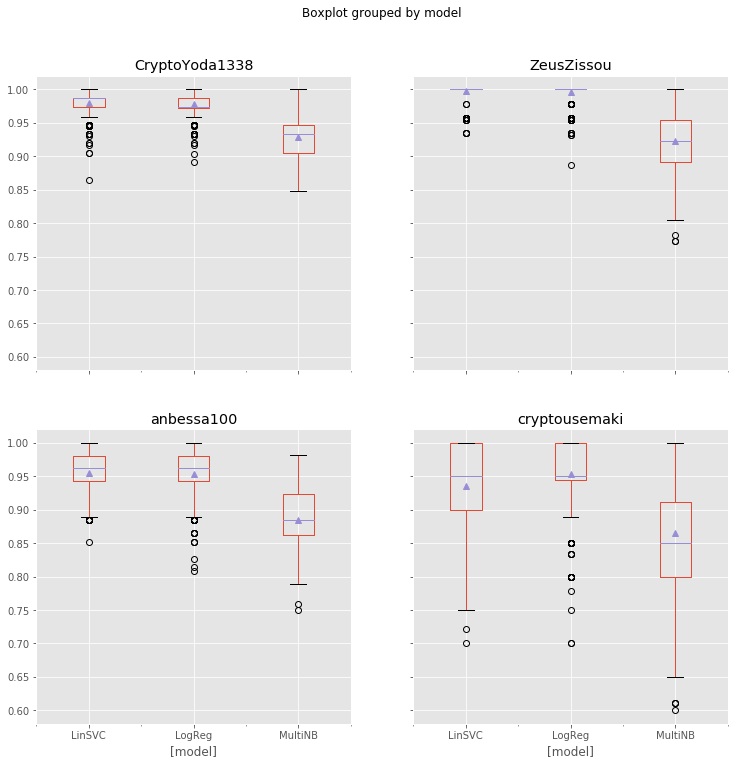

In [24]:
df_acc_res = get_all_scores(res_dict, 'full_test_accs')
df_acc_res.boxplot(by='model', figsize=(12,12), showmeans = True)

### 4b) Test AUC Scores

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001D6E800F2E8>,
      dtype=object)

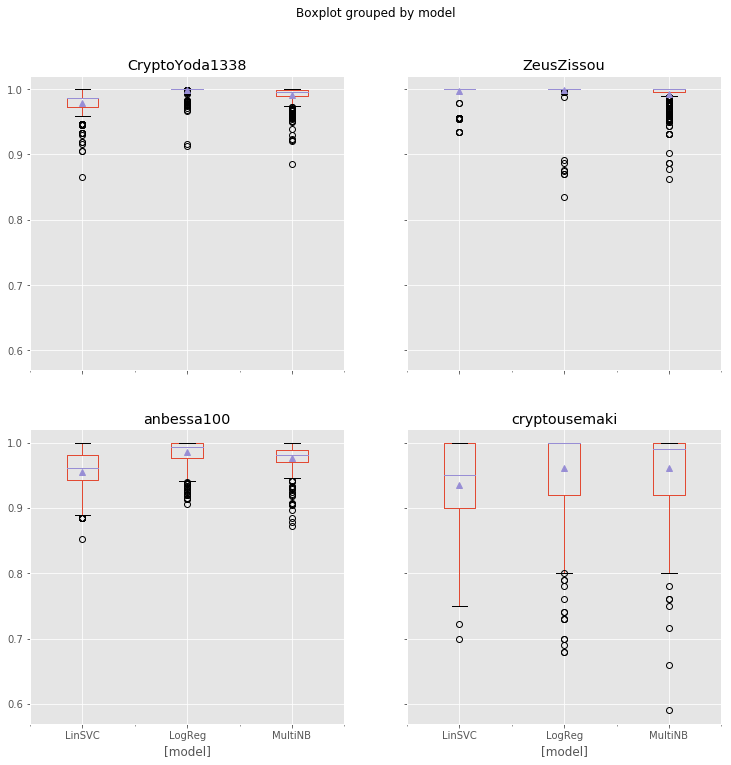

In [25]:
df_auc_res = get_all_scores(res_dict, 'full_test_aucs')
df_auc_res.boxplot(by='model', figsize=(12,12), showmeans = True)

### 4c) Information Gain

In [26]:
df_null_res = get_all_scores(res_dict, 'full_test_null_accs')

dict_res_test_ig = {}
dict_res_test_ig['model'] = df_acc_res['model']
for user in all_users[1:5]:
    test_ig = [df_acc_res[user][pos] - df_null_res[user][pos] for pos in range(len(df_acc_res))]
    dict_res_test_ig[user] = test_ig

df_test_ig = pd.DataFrame(dict_res_test_ig)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001D6EBD26438>,
      dtype=object)

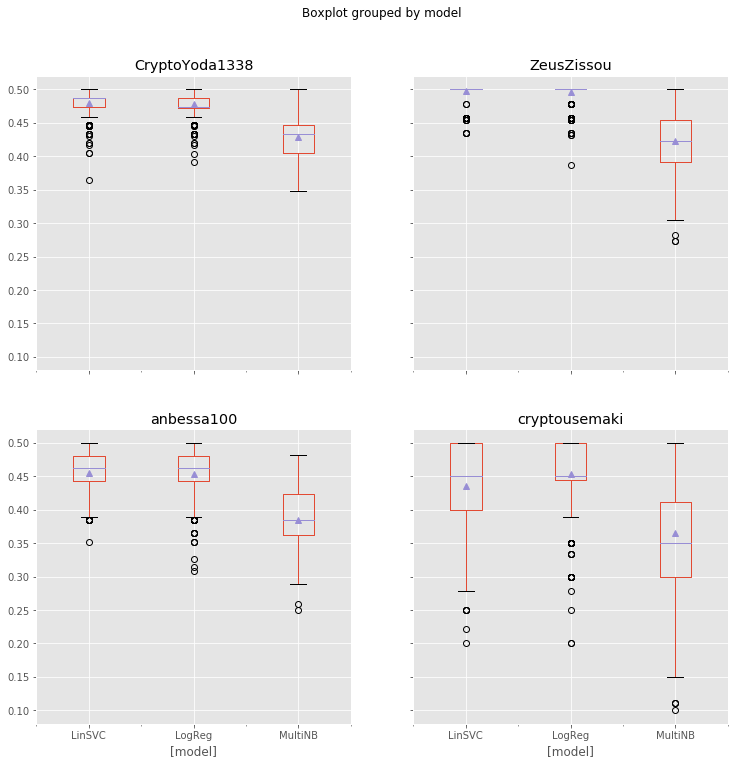

In [27]:
df_test_ig.boxplot(by='model', figsize=(12,12), showmeans = True)